In [1]:
from utils import *

### Load data

In [2]:
data = load_data("data_drop.csv")
columns_cookbook = load_data("owid-co2-codebook.csv")

In [3]:
data.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_coal_co2', 'cumulative_gas_co2', 'cumulative_oil_co2',
       'energy_per_capita', 'gas_co2', 'gas_co2_per_capita', 'oil_co2',
       'oil_co2_per_capita', 'primary_energy_consumption',
       'share_global_cement_co2', 'share_global_co2', 'share_global_coal_co2',
       'share_global_cumulative_cement_co2', 'share_global_cumulative_co2',
       'share_global_cumulative_coal_co2', 'share_global_cumulative_gas_co2',
       'share_global_cumulative_oil_co2', 'share_global_gas_co2',
       'share_global_oil_co2', 'lat', 'long', 'continent'],
      dtype='object')

In [4]:
cols_desc_dict = get_cols_description(columns_cookbook)

In [5]:
cols_desc_dict["co2"]

'Annual production-based emissions of carbon dioxide (CO2), measured in million tonnes. This is based on territorial emissions, which do not account for emissions embedded in traded goods.'

In [6]:
data.shape

(3638, 39)

### Number of countries per Continent

In [7]:
data.groupby(["continent"])['country'].nunique()

continent
Africa           13
Asia             33
Europe           37
North America     8
Oceania           2
South America     8
Name: country, dtype: int64

In [8]:
data[data["continent"] == "South America"]["country"].unique()

array(['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Peru',
       'Uruguay', 'Venezuela'], dtype=object)

### Number of observations per country

In [9]:
data.groupby(["continent", "country"]).size().mean()

36.01980198019802

In [10]:
data.groupby("country").size()

country
Afghanistan    39
Albania        37
Algeria        53
Argentina      54
Armenia        22
               ..
Uruguay        21
Uzbekistan     34
Venezuela      53
Vietnam        35
Yemen          10
Length: 101, dtype: int64

In [11]:
data.groupby(["country","year"]).size()

country      year
Afghanistan  1980    1
             1981    1
             1982    1
             1983    1
             1984    1
                    ..
Yemen        2014    1
             2015    1
             2016    1
             2017    1
             2018    1
Length: 3638, dtype: int64

In [12]:
data.groupby(["continent","country", "year"]).agg("sum")

/var/folders/mq/scw6sc915l354s4fy_xnvwv40000gn/T/ipykernel_33304/2135370011.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(["continent","country", "year"]).agg("sum")


population           gdp  cement_co2  \
continent     country   year                                         
Africa        Algeria   1965  12550880.0  3.566198e+10       0.367   
                        1966  12902626.0  3.393263e+10       0.327   
                        1967  13275020.0  3.709477e+10       0.360   
                        1968  13663581.0  4.142389e+10       0.429   
                        1969  14061724.0  4.538746e+10       0.469   
...                                  ...           ...         ...   
South America Venezuela 2014  30042972.0  5.983983e+11       3.131   
                        2015  30081826.0  5.589242e+11       3.237   
                        2016  29851248.0  4.564771e+11       2.879   
                        2017  29402480.0  3.849426e+11       3.166   
                        2018  28887118.0  3.094130e+11       2.760   

                              cement_co2_per_capita      co2  co2_growth_abs  \
continent     country   year                                                   
Africa        Algeria   1965                  0.029    6.589           0.945   
                        1966                  0.025    8.421           1.832   
                        1967                  0.027    8.432           0.011   
                        1968                  0.031    9.050           0.619   
                        1969                  0.033   11.263           2.213   
...                                             ...      ...             ...   
South America Venezuela 2014                  0.104  186.708         -20.717   
                        2015                  0.108  180.124          -6.584   
                        2016                  0.096  169.477         -10.647   
                        2017                  0.108  161.536          -7.941   
                        2018                  0.096  120.177         -41.359   

                              co2_growth_prct  co2_per_capita  co2_per_gdp  \
continent     country   year                                                 
Africa        Algeria   1965            16.75           0.525        0.185   
                        1966            27.81           0.653        0.248   
                        1967             0.13           0.635        0.227   
                        1968             7.34           0.662        0.219   
                        1969            24.45           0.801        0.248   
...                                       ...             ...          ...   
South America Venezuela 2014            -9.99           6.215        0.312   
                        2015            -3.53           5.988        0.322   
                        2016            -5.91           5.677        0.371   
                        2017            -4.69           5.494        0.420   
                        2018           -25.60           4.160        0.388   

                              co2_per_unit_energy  ...  share_global_coal_co2  \
continent     country   year                       ...                          
Africa        Algeria   1965                0.266  ...                   0.00   
                        1966                0.283  ...                   0.01   
                        1967                0.299  ...                   0.00   
                        1968                0.299  ...                   0.00   
                        1969                0.336  ...                   0.01   
...                                           ...  ...                    ...   
South America Venezuela 2014                0.193  ...                   0.00   
                        2015                0.189  ...                   0.00   
                        2016                0.204  ...                   0.00   
                        2017                0.199  ...                   0.00   
                        2018                0.175  ...                   0.00   

         

In [13]:
us_data = get_observed_values_by_country(data, "United States")

In [14]:
us_data

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_cement_co2,share_global_cumulative_co2,share_global_cumulative_coal_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_gas_co2,share_global_oil_co2,lat,long,continent
3431,United States,1965,USA,199733664.0,4.156141e+12,33.090,0.166,3399.342,135.231,4.14,...,24.87,37.62,31.67,80.86,50.72,63.61,33.19,39.78373,-100.445882,North America
3432,United States,1966,USA,201895760.0,4.428300e+12,34.360,0.170,3571.208,171.867,5.06,...,24.13,37.38,31.46,79.48,49.54,62.87,32.12,39.78373,-100.445882,North America
3433,United States,1967,USA,203905072.0,4.538979e+12,33.387,0.164,3705.254,134.046,3.75,...,23.42,37.15,31.29,78.11,48.39,61.51,31.30,39.78373,-100.445882,North America
3434,United States,1968,USA,205805744.0,4.754926e+12,35.102,0.171,3840.702,135.448,3.66,...,22.75,36.91,31.10,76.73,47.24,60.05,30.55,39.78373,-100.445882,North America
3435,United States,1969,USA,207659280.0,4.903770e+12,35.477,0.171,4034.926,194.223,5.06,...,22.09,36.65,30.91,75.40,46.10,59.60,29.79,39.78373,-100.445882,North America
3436,United States,1970,USA,209513344.0,4.912636e+12,34.709,0.166,4339.471,304.545,7.55,...,21.41,36.39,30.71,74.19,44.99,59.16,29.97,39.78373,-100.445882,North America
3437,United States,1971,USA,211384080.0,5.065682e+12,35.291,0.167,4365.247,25.776,0.59,...,20.79,36.10,30.49,72.88,43.91,56.75,29.12,39.78373,-100.445882,North America
3438,United States,1972,USA,213269808.0,5.334297e+12,36.299,0.170,4572.791,207.544,4.75,...,20.18,35.82,30.29,71.52,42.91,54.38,29.22,39.78373,-100.445882,North America
3439,United States,1973,USA,215178800.0,5.637203e+12,36.690,0.170,4784.823,212.032,4.64,...,19.59,35.54,30.11,70.12,41.96,51.79,28.94,39.78373,-100.445882,North America
3440,United States,1974,USA,217114896.0,5.621366e+12,36.580,0.169,4620.820,-164.003,-3.43,...,19.07,35.25,29.93,68.65,41.09,48.41,28.18,39.78373,-100.445882,North America


# Question 0

Who are the top emittors per continent?

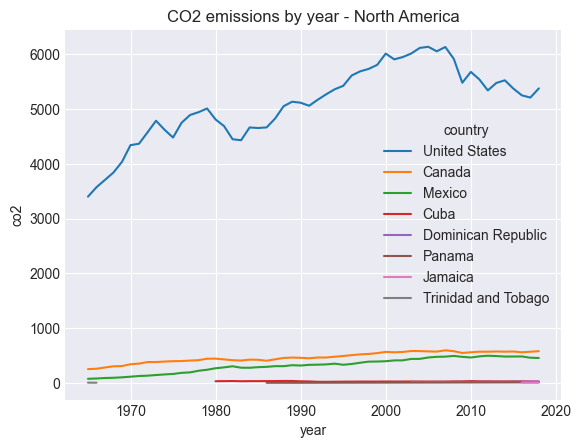

In [15]:
plot_co2_emissions_by_continent(data, "North America", top=10)
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

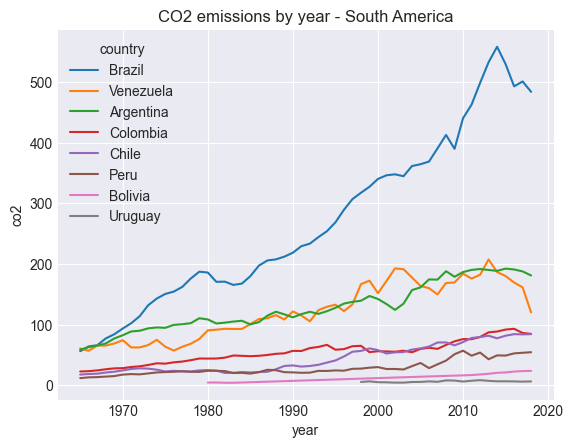

In [16]:
plot_co2_emissions_by_continent(data, "South America")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

/Users/alexpeters/Documents/SCHOOL/STAT CLASS/STAT 650/Midterm/Repo/STAT650-midterm/utils.py:156: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


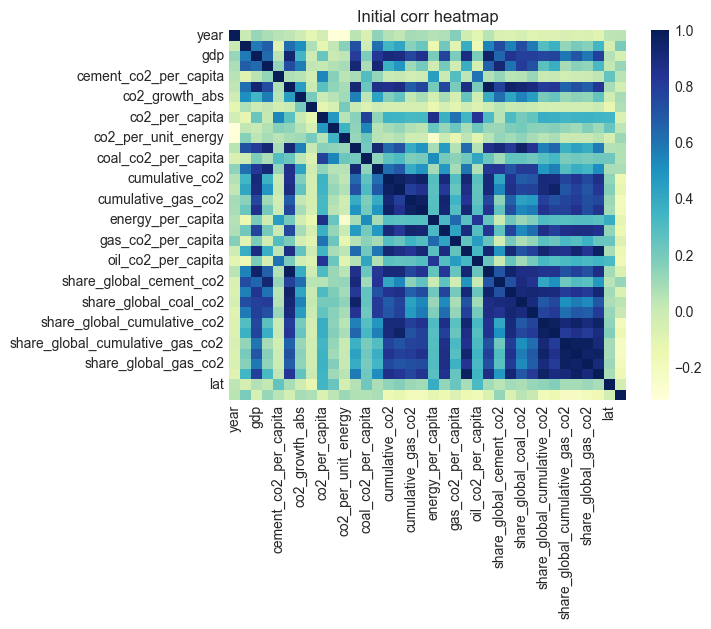

In [17]:
plot_corr_heatmap(data)
plt.title("Initial corr heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

#### Alex Analysis

First, I want to assess the multicollinearity of the features to help me decide which to remove. To accomplish this, I will look at variance inflation factors, which are only defined for numeric variables. So, I will drop the categorical columns and create a new dataframe with only numeric data.

In [18]:
data.dtypes

country                                object
year                                    int64
iso_code                               object
population                            float64
gdp                                   float64
cement_co2                            float64
cement_co2_per_capita                 float64
co2                                   float64
co2_growth_abs                        float64
co2_growth_prct                       float64
co2_per_capita                        float64
co2_per_gdp                           float64
co2_per_unit_energy                   float64
coal_co2                              float64
coal_co2_per_capita                   float64
cumulative_cement_co2                 float64
cumulative_co2                        float64
cumulative_coal_co2                   float64
cumulative_gas_co2                    float64
cumulative_oil_co2                    float64
energy_per_capita                     float64
gas_co2                           

To compute variance inflation factors, I need to only consider numeric data. So I create a new dataframe with only the numeric data.

In [19]:
numeric_data = data.drop(['country','iso_code','continent'], axis=1)

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i)
                          for i in range(len(numeric_data.columns))]

vif_data 

,feature,VIF
0,year,0.001174
1,population,8.088382
2,gdp,133.298320
3,cement_co2,369.747250
4,cement_co2_per_capita,3.145468
5,co2,66367.038212
6,co2_growth_abs,2.031648
7,co2_growth_prct,1.143627
8,co2_per_capita,941.258449
9,co2_per_gdp,2.248148


In [21]:
vif_data[vif_data.VIF >= 500].feature.tolist()

['co2',
 'co2_per_capita',
 'coal_co2',
 'cumulative_co2',
 'cumulative_coal_co2',
 'cumulative_gas_co2',
 'cumulative_oil_co2',
 'gas_co2',
 'oil_co2',
 'share_global_co2',
 'share_global_coal_co2',
 'share_global_cumulative_co2',
 'share_global_cumulative_coal_co2',
 'share_global_cumulative_oil_co2',
 'share_global_oil_co2']

I'll now create a correlation map of those variables with particularly high VIFs, so that I can assess which I'd like to remove for the final analysis.

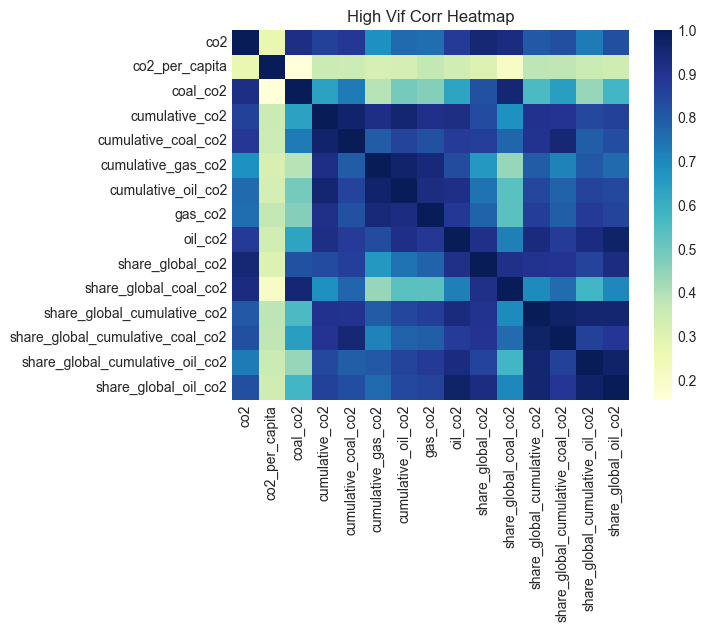

In [22]:
plot_corr_heatmap(data.loc[:, vif_data[vif_data.VIF >= 500].feature.tolist()])
plt.title("High Vif Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

It's unsurprising that CO2 emissions are highly correlated with cumulative CO2 and CO2 emitted from different sources. Similarly, it's unsurprising that the share of overall global CO2 is highly correlated with cumulative global share, both overall and from different sources. Since all of these variables could be considered interesting responses, I am only going to keep overall CO2 emissions and the share of global CO2 emissions, and drop the rest.

In [23]:
data = data.drop(['co2_per_capita',
                 'coal_co2',
                 'cumulative_co2',
                 'cumulative_coal_co2',
                 'cumulative_gas_co2',
                 'cumulative_oil_co2',
                 'gas_co2',
                 'oil_co2',
                 'share_global_coal_co2',
                 'share_global_cumulative_co2',
                 'share_global_cumulative_coal_co2',
                 'share_global_cumulative_oil_co2',
                 'share_global_oil_co2'], axis=1)

/Users/alexpeters/Documents/SCHOOL/STAT CLASS/STAT 650/Midterm/Repo/STAT650-midterm/utils.py:156: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


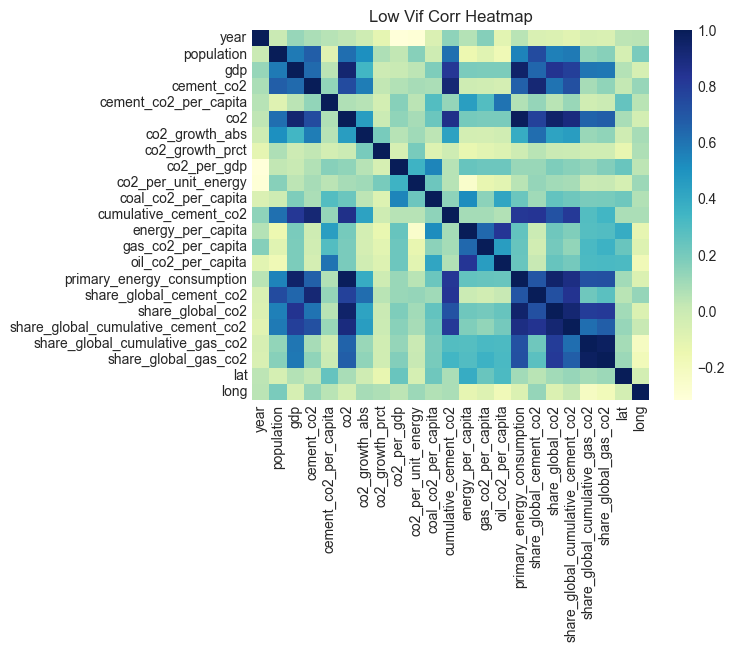

In [24]:
plot_corr_heatmap(data)
plt.title("Low Vif Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

Using this heatmap, I can also see that there are many more variables that are still parts of the CO2 whole, even though they do not have particularly high VIFs. I will remove these as well, because I am interested in total CO2 emissions rather than the composition of CO2 emissions.

In [25]:
data = data.drop(['cement_co2', 'cement_co2_per_capita', 'co2_growth_abs',
                  'coal_co2_per_capita', 'cumulative_cement_co2', 'gas_co2_per_capita',
                  'oil_co2_per_capita', 'share_global_cement_co2', 'share_global_co2',
                  'share_global_cumulative_cement_co2', 'share_global_cumulative_gas_co2',
                  'share_global_gas_co2'], axis=1)

/Users/alexpeters/Documents/SCHOOL/STAT CLASS/STAT 650/Midterm/Repo/STAT650-midterm/utils.py:156: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


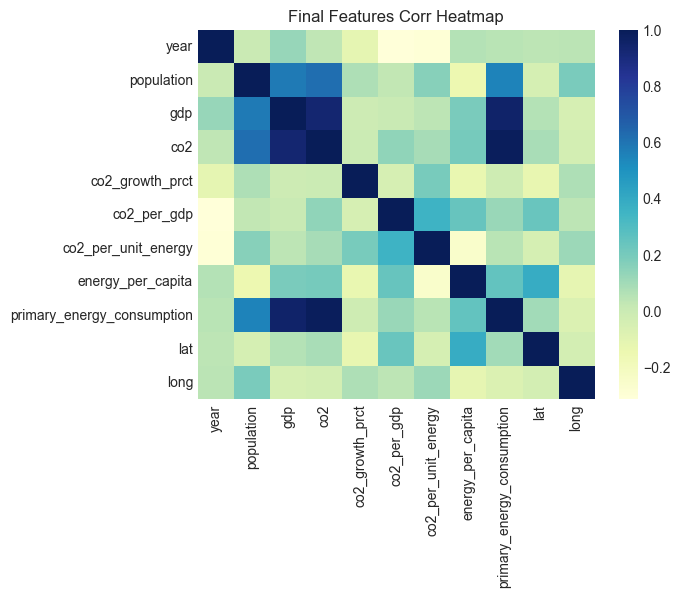

In [26]:
plot_corr_heatmap(data)
plt.title("Final Features Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

Now that I've picked out only the variables that I'm interested in keeping in my analysis, I want to use the data to answer a few questions.

# Question 1

### Which countries from each continent has seen the greatest increases and decreases in CO2 efficiency from 2000 to 2018?

I will measure change in CO2 efficiency by looking at the percent change in `co2_per_unit_energy` from 2000 to 2018.

In [27]:
# get countries that have observations in 2000 or 2018
data_2000 = data[data.year == 2000]
data_2018 = data[data.year == 2018]

# get list of countries that have observations in both years
common_countries = list(set(data_2000.country) & set(data_2018.country))

# stack dataframes 
data_2000_2018 = pd.concat(
    [data_2000[[country in common_countries for country in data_2000.country]],
    data_2018[[country in common_countries for country in data_2018.country]]]
).sort_values(['country', 'year'])

data_2000_2018

,country,year,iso_code,population,gdp,co2,co2_growth_prct,co2_per_gdp,co2_per_unit_energy,energy_per_capita,primary_energy_consumption,lat,long,continent
20,Afghanistan,2000,AFG,20779958.0,1.128379e+10,0.758,-6.40,0.067,0.128,284.582,5.914,33.768006,66.238514,Asia
38,Afghanistan,2018,AFG,37171920.0,6.759497e+10,8.345,21.65,0.123,0.199,1129.595,41.989,33.768006,66.238514,Asia
59,Albania,2000,ALB,3129246.0,1.521426e+10,3.004,0.99,0.198,0.105,9181.736,28.732,41.000028,19.999962,Europe
75,Albania,2018,ALB,2882735.0,3.400911e+10,4.734,-10.71,0.139,0.114,14455.136,41.670,41.000028,19.999962,Europe
111,Algeria,2000,DZA,31042238.0,2.085541e+11,82.221,-10.31,0.394,0.274,9662.501,299.946,28.000027,2.999983,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539,Uzbekistan,2018,UZB,32476232.0,3.368748e+11,114.732,7.07,0.341,0.215,16432.637,533.670,41.323730,63.952810,Asia
3575,Venezuela,2000,VEN,24192450.0,3.305142e+11,151.870,-11.99,0.460,0.188,33825.332,818.318,8.001871,-66.110932,South America
3592,Venezuela,2018,VEN,28887118.0,3.094130e+11,120.177,-25.60,0.388,0.175,24215.373,699.512,8.001871,-66.110932,South America
3609,Vietnam,2000,VNM,79910416.0,2.196489e+11,52.601,12.18,0.240,0.251,2679.863,214.149,15.926666,107.965086,Asia


In [28]:
# group with country and continent and get percent change
pct_change_co2_per_unit_energy = data_2000_2018.loc[:,['country','co2_per_unit_energy','continent']]\
                                    .groupby(['continent','country'], group_keys=True)\
                                    .apply(pd.Series.pct_change)\
                                    .dropna().reset_index().drop('level_2', axis=1)

Here are the countries with the greatest increase in CO2 efficiency (largest % drop in CO2 per unit energy):

In [29]:
pct_change_co2_per_unit_energy.sort_values('co2_per_unit_energy').groupby(['continent']).head(1)

,continent,country,co2_per_unit_energy
10,Asia,Hong Kong,-0.421569
52,Europe,North Macedonia,-0.381074
3,Africa,Nigeria,-0.247863
75,South America,Peru,-0.184466
67,North America,Mexico,-0.139918
69,Oceania,Australia,-0.025926


/var/folders/mq/scw6sc915l354s4fy_xnvwv40000gn/T/ipykernel_33304/2816408226.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=data[[country in ['Hong Kong', 'North Macedonia', 'Nigeria', 'Peru', 'Mexico', 'Australia']


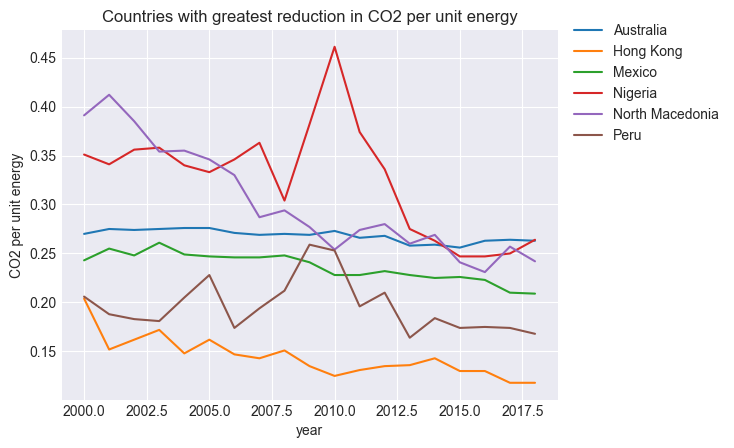

In [30]:
sns.lineplot(data=data[[country in ['Hong Kong', 'North Macedonia', 'Nigeria', 'Peru', 'Mexico', 'Australia']
                       for country in data.country.tolist()]][data.year >= 2000],
             x='year', y='co2_per_unit_energy', hue='country')
plt.title('Countries with greatest reduction in CO2 per unit energy')
plt.ylabel('CO2 per unit energy')
plt.legend(bbox_to_anchor=(1.35, 1.05))
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

And here are the countries with the smallest increase (or decrease) in CO2 efficiency:

In [31]:
pct_change_co2_per_unit_energy.sort_values('co2_per_unit_energy', ascending=False).groupby(['continent']).head(1)

,continent,country,co2_per_unit_energy
25,Asia,Tajikistan,2.368421
34,Europe,Bosnia and Herzegovina,0.419811
4,Africa,South Africa,0.028213
70,Oceania,New Zealand,-0.013889
73,South America,Chile,-0.021164
65,North America,Canada,-0.088050


/var/folders/mq/scw6sc915l354s4fy_xnvwv40000gn/T/ipykernel_33304/3499655396.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=data[[country in ['Tajikistan', 'Bosnia and Herzegovina', 'South Africa', 'New Zealand', 'Chile', 'Canada']


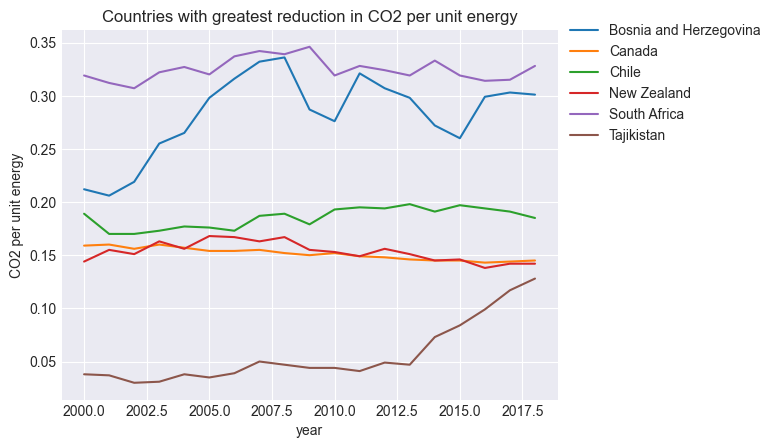

In [32]:
sns.lineplot(data=data[[country in ['Tajikistan', 'Bosnia and Herzegovina', 'South Africa', 'New Zealand', 'Chile', 'Canada']
                       for country in data.country.tolist()]][data.year >= 2000],
             x='year', y='co2_per_unit_energy', hue='country')
plt.title('Countries with greatest reduction in CO2 per unit energy')
plt.ylabel('CO2 per unit energy')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

# Question 2

### What is the relationship between population and CO2 emission?

First, we will look at the relationship between population and CO2 emissions for all countries that had measurements in 2018.

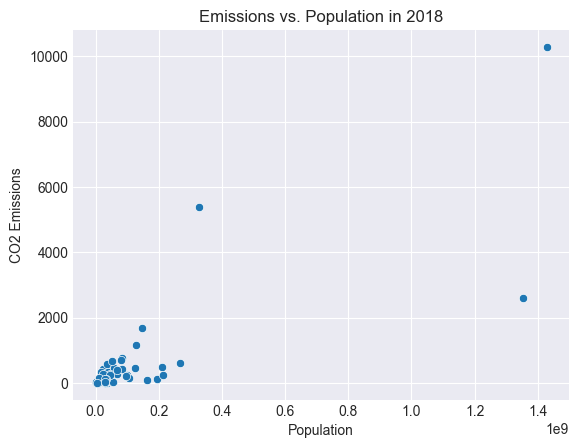

In [39]:
data_2018 = data[data.year == 2018]

sns.scatterplot(data=data_2018, x='population', y='co2')
plt.xlabel("Population")
plt.ylabel("CO2 Emissions")
plt.title("Emissions vs. Population in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

Since this plot has some very clear outliers, unequal variances across the range of the data, and a positive relationship, we will try a log-log transformation.

In [40]:
import copy

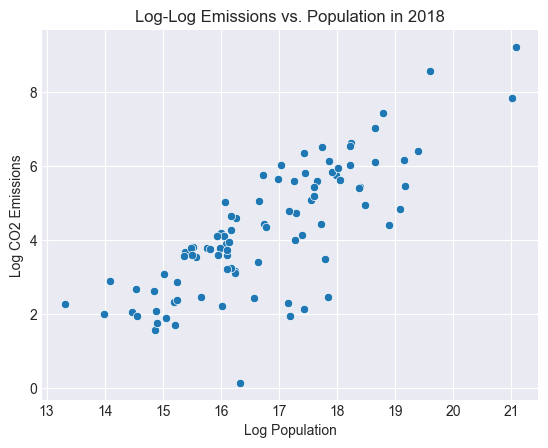

In [46]:
data_2018_loglog = copy.copy(data_2018)
data_2018_loglog['population'] = np.log(data_2018_loglog['population'])
data_2018_loglog['co2'] = np.log(data_2018_loglog['co2'])

sns.scatterplot(data=data_2018_loglog, x='population', y='co2')
plt.xlabel("Log Population")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log Emissions vs. Population in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

Now that we have a linear, equal-variance relationship to learn, we can do linear regression and use the learned parameters to answer questions about the relationship between population and CO2 emissions.

In [47]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
regressor.fit(data_2018_loglog['population'].values.reshape(-1,1),
              data_2018_loglog['co2'].values.reshape(-1,1))

LinearRegression()

In [48]:
regressor.coef_

array([[0.89805994]])

Because we used a log-log regression model, the interpretation of the model parameters is different than with an ordinary linear regression model. In this case, we see that if population increases by 8.9%, then CO2 emissions increase by 10%.

Lastly, we can plot the learned linear model and a 95% confidence interval on the slope.

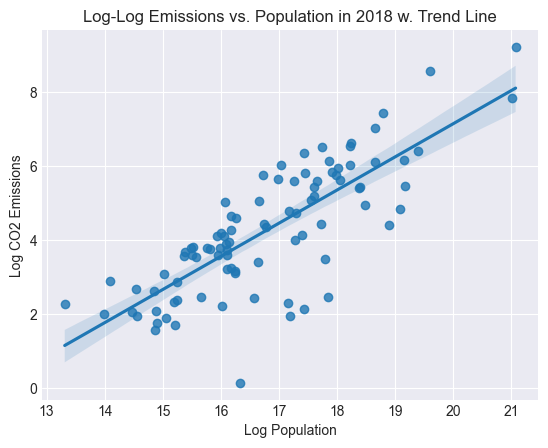

In [50]:
sns.regplot(data=data_2018_loglog, x='population', y='co2')
plt.xlabel("Log Population")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log Emissions vs. Population in 2018 w. Trend Line")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

# Question 3

### What is the relationship between GDP and CO2 emissions?

What is the relationship between CO2 and GDP?

Spatial analysis / plots of countries by CO2 emissions?

Comparisons of top 3 countries per continent, compare across continents